In [14]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import numpy as np
import torch
import datetime

from src.pipeline.repository import Repository
from src.data.utils import get_annotations_ends
from pyapnea.oscar.oscar_constants import ChannelID


In [15]:
sr = 25
len_respi = 91
#len_respi = 180

def plot_sftf(data, filename=None):
    amp = 2*np.sqrt(2)
    f1, t1, Zxx1 = signal.stft(data, sr, nperseg=len_respi)
    plt.pcolormesh(t1, f1, np.abs(Zxx1), vmin=0, vmax=amp, shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if filename is not None:
        plt.savefig(filename, format='png')
    plt.show()

# https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python
def plot_fft(data, filename=None):
    N = len(data)
    T = 1.0 / sr
    fft_res = np.fft.fft(data)
    xf = np.fft.fftfreq(N, T)
    firstNedInd = np.argmax(xf < 0)
    freqAxisPos = xf[0:firstNedInd]
    sigFFTPos = fft_res[0:firstNedInd]
    #xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fig, ax = plt.subplots()
    ax.set(xlabel='Fréquence')
    ax.plot(freqAxisPos, np.abs(sigFFTPos))    
    if filename is not None:
        plt.savefig(filename, format='pdf')
    plt.show()
    # Phase not really interresting
    # fig2, ax2 = plt.subplots()
    # ax2.plot(freqAxisPos, np.angle(sigFFTPos))
    # plt.show()
    return sigFFTPos, xf

In [16]:
data_repo_path = os.path.join('..', 'data', 'repository')
repo = Repository(data_repo_path)

# RAW Dataset

In [17]:
raw_dataset = repo.load_dataset('1616f850-17d1-4990-a6fe-54071fccd005', 'numpy', 'train')

In [18]:
print('Nombre de session :', len(raw_dataset))

Nombre de session : 6370


In [19]:
x1, y1 = raw_dataset[1]
print(x1.shape)
print(y1.shape)

(500, 1)
(500, 1)


In [20]:
x1f = x1.flatten()
y1f = y1.flatten()
print(x1f.shape)
print(y1f.shape)

(500,)
(500,)


In [21]:
print('longueur (point)', len(x1), 'longueur (min):', len(x1)*40/1000/60)

longueur (point) 500 longueur (min): 0.3333333333333333


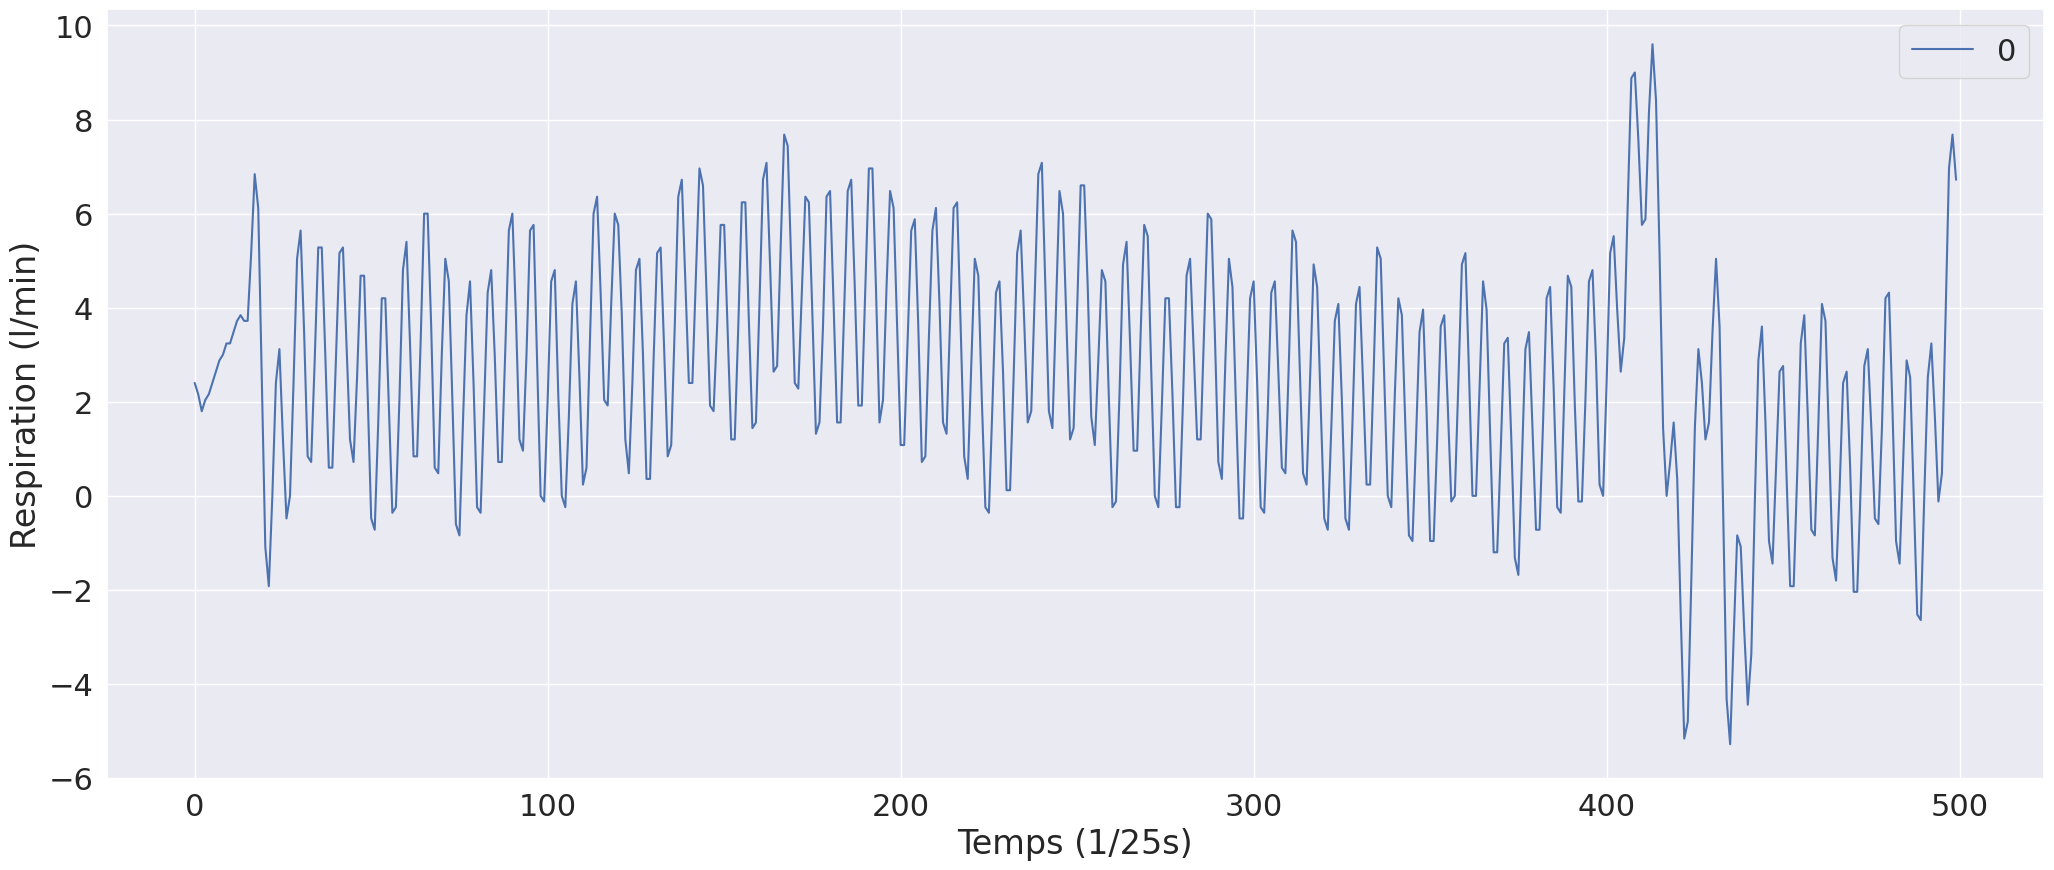

In [22]:
sns.set(rc={'figure.figsize':(25,10)}, font_scale=2)
fig, ax = plt.subplots()
ax.set(xlabel='Temps (1/25s)', ylabel='Respiration (l/min)')
sns.lineplot(x1)
plt.savefig("OneSession.pdf", format='pdf')

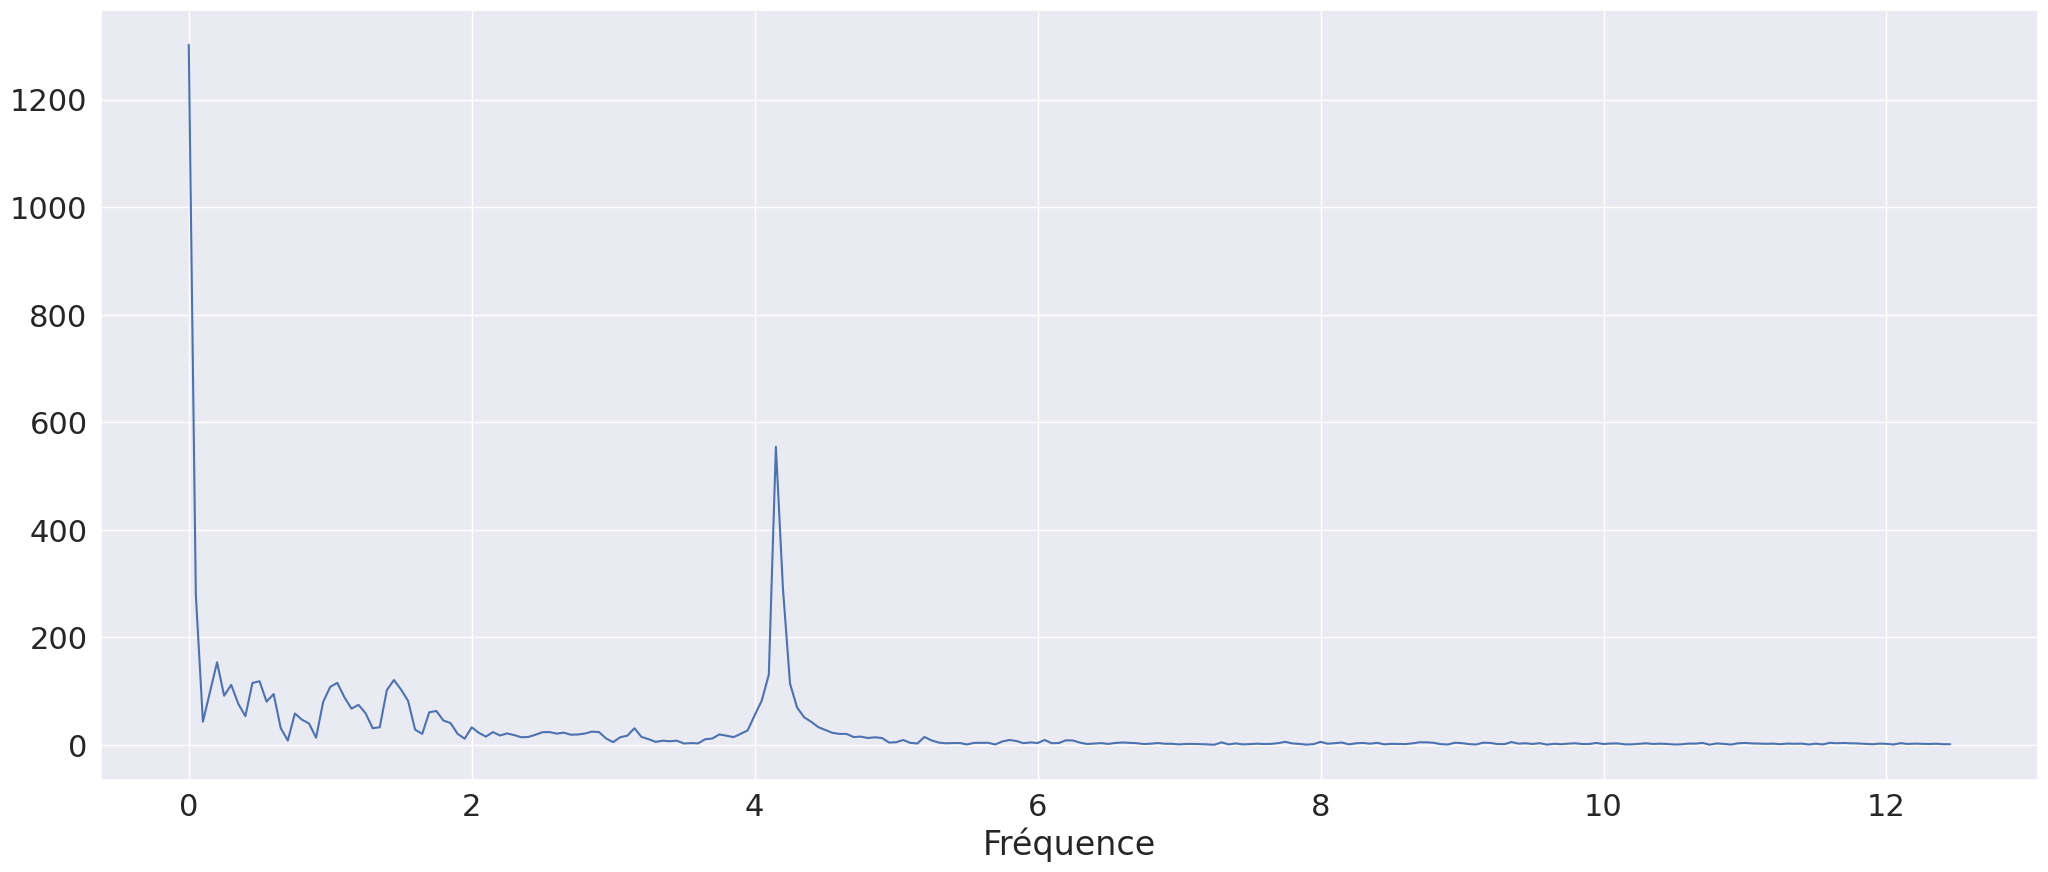

In [23]:
# FFT
fft1, xf1 = plot_fft(x1f, "OneSessionFFT.pdf")

In [24]:
print(len(fft1), len(xf1))
idx_max = np.argmax(np.abs(fft1))
print('frequence respiration', xf1[idx_max])
print('Longueur respiration plus frequente', 1/xf1[idx_max], 's')

250 500
frequence respiration 0.0
Longueur respiration plus frequente inf s


/tmp/ipykernel_74473/1887618834.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  print('Longueur respiration plus frequente', 1/xf1[idx_max], 's')


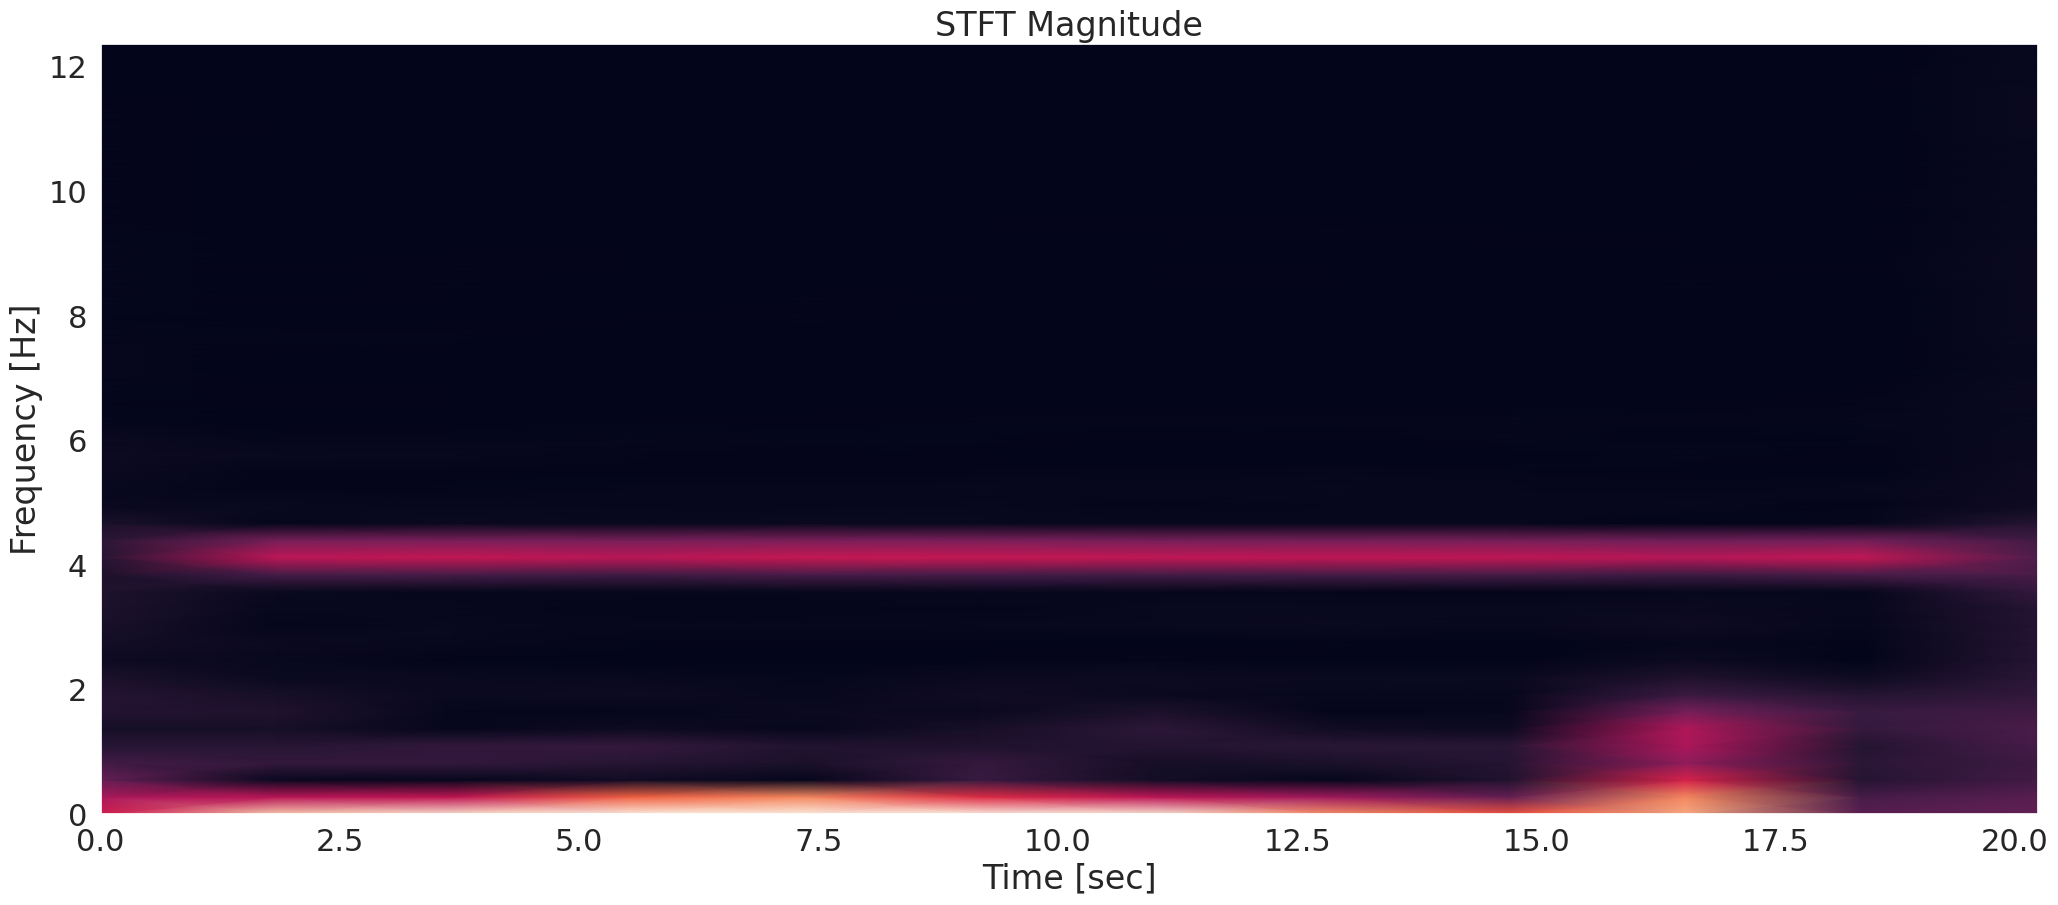

In [25]:
# STFT
plot_sftf(x1f, 'OneSessionSTFT.png')


# Processed Dataset (windowed) (numpy)

In [26]:
windowed_dataset = repo.load_dataset('4a9769fc-3a48-40a7-a54d-e1d7922ee0a8', 'numpy')

FileNotFoundError: [Errno 2] No such file or directory: '/home/julien/prog/apnea/data/repository/conf/4a9769fc-3a48-40a7-a54d-e1d7922ee0a8.yaml'

In [ ]:
print('nombre d''elements:', len(windowed_dataset))

In [ ]:
x2, y2 = windowed_dataset[0]
x2

In [ ]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale=2)
fig, ax = plt.subplots()
ax.set(xlabel='Temps (1/25s)', ylabel='Respiration (l/min)')
sns.lineplot(x2)
plt.savefig("NormalBreathing.pdf", format='pdf')

In [ ]:
x2f = x2.flatten()
y2f = y2.flatten()
print(x2f.shape)
print(y2f.shape)

In [ ]:
fft2, xf2 = plot_fft(x2f, 'NormalBreathingFFT.pdf')

In [ ]:
print(len(fft2), len(xf2))
idx_max2 = np.argmax(np.abs(fft2))
print('frequence respiration', xf2[idx_max2])
print('Longueur respiration plus frequente', 1/xf2[idx_max2], 's')

In [ ]:
plot_sftf(x2f, 'NormalBreathingSFTF.png')

In [ ]:
# find one with apnea event
index_dataset = {}
list_df_annot = []
res = []
with tqdm(total=len(windowed_dataset)) as pbar:
    for x,y in windowed_dataset:
        if 1 in y:
            list_df_annot.append((x,y))
            res.append((x,y))
            if len(res) > 10:
                break
        pbar.update(1)

In [ ]:
(x3, y3) = res[9]
fig, ax = plt.subplots()
ax.set(xlabel='Temps (1/25s)', ylabel='Respiration (l/min)')
sns.lineplot(x3)
plt.savefig("ApneaBreathing.pdf", format='pdf')

In [ ]:
x3f = x3.flatten()
y3f = y3.flatten()

In [ ]:
fft3, xf3 = plot_fft(x3f, 'ApneaBreathingFFT.pdf')

In [ ]:
idx_max3 = np.argmax(np.abs(fft3))
print('frequence respiration', xf2[idx_max3])
print('Longueur respiration plus frequente', 1/xf2[idx_max3], 's')

In [ ]:
plot_sftf(x3f, 'ApneaBreathingSFTF.png')

# Processed Dataset (windowed) (dataframe)

In [ ]:
optional_args = {'channel_ids': [ChannelID.CPAP_FlowRate.value, ChannelID.CPAP_Pressure.value]} 
raw_dataset_df = repo.load_dataset('1601153a-d0b4-4960-be24-39295454ef96', 'dataframe', optional_args)

In [ ]:
df1 = raw_dataset_df[0]
df1.reset_index(inplace=True)
df1.sort_values('time_utc', inplace=True)
df1['Pressure'].fillna(method='ffill', inplace=True)

In [ ]:
annot1 = get_annotations_ends(df1)

In [ ]:
dfc1 = df1[['FlowRate', 'ApneaEvent', 'Pressure', 'time_utc']]
dfm1 = dfc1.melt('time_utc', var_name='cols', value_name='vals')
dfm1

In [ ]:
event_time = annot1['time_utc'].iloc[0]
sns.set(rc={'figure.figsize':(25,15)}, font_scale=1.5)
fig, ax = plt.subplots()

#ax.set_ylim(-40, 50)
ax.set_xlim(event_time - datetime.timedelta(seconds=30), event_time + datetime.timedelta(seconds=30))
ax.set(xlabel='Temps', ylabel='Évenements')
sns.lineplot(data=dfm1[dfm1['cols']!='FlowRate'],x='time_utc', y='vals', hue='cols', palette=['r', 'g'], ax = ax)
ax2 = ax.twinx()
ax2.set(xlabel='Temps', ylabel='FlowRate')
# warning : should not interpolate between points...
sns.lineplot(data=dfm1[dfm1['cols']=='FlowRate'],x='time_utc', y='vals', hue='cols', palette=['b'], ax = ax2)
# for a in annot1['time_utc']:
#    plt.axvline(x=a, color='r', linewidth=3)
plt.savefig("PressureExplained.pdf", format='pdf')

# PCA sur le signal fenetré

In [ ]:
pi_winds = repo.load_dataset('2041cb8a-11e7-472e-93e1-ad3af8d2c344', 'numpy')
np_ds = np.array(pi_winds)
X = np_ds[:,0,:,:]
Y = np_ds[:,1,:,:]
X = X.reshape((X.shape[0],X.shape[1]))
Y = Y.reshape((Y.shape[0],Y.shape[1]))
print(X.shape, Y.shape)

In [ ]:
Yc = Y.sum(axis=1)
print(Yc.shape)

In [ ]:
Yc[Yc>=1] = 1
print(len(Yc[Yc==1]))

In [ ]:
print(X[0])

In [ ]:
# https://machinelearningmastery.com/principal-component-analysis-for-visualization/
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])

Xt = pipe.fit_transform(X)

In [ ]:
sns.set(rc={'figure.figsize':(25,15)}, font_scale=2)
sns.scatterplot(x=Xt[:,0], y=Xt[:,1], hue=Yc)
plt.savefig("KernelPCA.pdf", format='pdf')
plt.show()

# Analyse des matrices confusion

In [ ]:
y = [0, 0, 0 , 1]
yh = [1, 0 , 0, 1]
from sklearn.metrics import confusion_matrix

c = confusion_matrix(y, yh)
print(c)

In [ ]:
c